In [69]:
import os
import sys
import random
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

from tqdm import tqdm
from itertools import chain
from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.transform import resize
from skimage.morphology import label

from keras.models import Model, load_model
from keras.layers import Input
from keras.layers import Conv2D, Conv2DTranspose
from keras.layers import MaxPooling2D
from keras.layers import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Part 1: Image classification
We will try to detect malignancies in dermatoscopic images using a subset of the [HAM10000](https://dataverse.harvard.edu/dataset.xhtml?persistentId=doi:10.7910/DVN/DBW86T) dataset. This subset will have 250 train and 250 validation images for each of four classes (totaling 1000 train and 1000 validation):

- **bcc:** basal cell carcinoma
- **bkl:** benign keratosis-like lesions
- **mel:** melanoma
- **nv:** melanocytic nevi

First, we'll download and unzip the data:

In [70]:
!gdown 1skd7oBu_xZtRP2Rtu5sXrGniDuxat0rU

Downloading...
From (original): https://drive.google.com/uc?id=1skd7oBu_xZtRP2Rtu5sXrGniDuxat0rU
From (redirected): https://drive.google.com/uc?id=1skd7oBu_xZtRP2Rtu5sXrGniDuxat0rU&confirm=t&uuid=05a01392-602f-4705-80e0-15e080ea2047
To: /content/data.zip
100% 608M/608M [00:08<00:00, 72.9MB/s]


In [71]:
import zipfile

# Unzip the dataset
local_zip = './data.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('./')
zip_ref.close()

In [72]:

base_dir = 'data/skin_cancer'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
batch_size=8
img_dim = 32

train_datagen = ImageDataGenerator(
    rescale=1./255
)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(img_dim, img_dim),
        batch_size=batch_size,
        class_mode='categorical')

validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(img_dim, img_dim),
        batch_size=batch_size,
        class_mode='categorical')

Found 1000 images belonging to 4 classes.
Found 1000 images belonging to 4 classes.


**Define a Keras [sequential](https://keras.io/guides/sequential_model/) model with:**

**1. An input layer with a shape of `img_dim`x`img_dim`x3**

**2. Two [Conv2D](https://keras.io/api/layers/convolution_layers/convolution2d/) layers with 8 3x3 filters each, 'relu' activation, and 'same' padding, and a [MaxPooling2D](https://keras.io/api/layers/pooling_layers/max_pooling2d/) layer with a window of 2x2 and a stride of 2x2**

**3. Two more [Conv2D](https://keras.io/api/layers/convolution_layers/convolution2d/) layers with 16 3x3 filters each, 'relu' activation, and 'same' padding, and another [MaxPooling2D](https://keras.io/api/layers/pooling_layers/max_pooling2d/) layer with a window of 2x2 and a stride of 2x2**

**4. Two more [Conv2D](https://keras.io/api/layers/convolution_layers/convolution2d/) layers with 32 3x3 filters each, 'relu' activation, and 'same' padding, and another [MaxPooling2D](https://keras.io/api/layers/pooling_layers/max_pooling2d/) layer with a window of 2x2 and a stride of 2x2**

**5. A [Flatten](https://keras.io/api/layers/reshaping_layers/flatten/) layer and a [Dense](https://keras.io/api/layers/core_layers/dense/) layer with 128 units and relu activation**

**6. An Dense layer to serve as the output layer**
- Hint: This network is solving a multiclass classification problem with 4 classes. Make sure the output layer has the appropriate units and activation!

In [73]:
# YOUR CODE HERE
model = tf.keras.models.Sequential(
    [   ### Part 1: Input
        tf.keras.Input(shape=(img_dim, img_dim, 3)), # part 1: img_dim = 32 from script above
        ### Part 2
        tf.keras.layers.Conv2D(8, (3,3), activation='relu', padding='same'), # (1/2) Conv2D layers with 8 3x3 filters, 'relu' activation, and 'same' padding
        tf.keras.layers.Conv2D(8, (3,3), activation='relu', padding='same'), # (2/2) Conv2D layers with 8 3x3 filters, 'relu' activation, and 'same' padding
        tf.keras.layers.MaxPooling2D(pool_size=(2,2), strides=(2,2)), #: (1/1) MaxPolling2D layer with a window of 2x2 and a stride of 2x2
        ### Part 3
        tf.keras.layers.Conv2D(16, (3,3), activation='relu', padding='same'), # (1/2) Conv2D layers with 16 3x3 filters, 'relu' activation, and 'same' padding
        tf.keras.layers.Conv2D(16, (3,3), activation='relu', padding='same'), #: (2/2) Conv2D layers with 16 3x3 filters, 'relu' activation, and 'same' padding
        tf.keras.layers.MaxPooling2D(pool_size=(2,2), strides=(2,2)), # (1/1) MaxPolling2D layer with a window of 2x2 and a stride of 2x2
        ### Part 4
        tf.keras.layers.Conv2D(32, (3,3), activation='relu', padding='same'), # (1/2) Conv2D layers with 32 3x3 filters, 'relu' activation, and 'same' padding
        tf.keras.layers.Conv2D(32, (3,3), activation='relu', padding='same'), #: (2/2) Conv2D layers with 32 3x3 filters, 'relu' activation, and 'same' padding
        tf.keras.layers.MaxPooling2D(pool_size=(2,2), strides=(2,2)), # (1/1) MaxPolling2D layer with a window of 2x2 and a stride of 2x2
        ### Part 5
        tf.keras.layers.Flatten(), # (1/1) Flatten layer
        tf.keras.layers.Dense(128, activation='relu'), # (1/1) Dense layer with 128 units and relu activation
        ### Part 6
        tf.keras.layers.Dense(4, activation='softmax') # (1/1) Dense layer to serve as the output layer
        #### Note from google: For a multiclass classification model in Keras, the appropriate activation function for the outer (output) layer is typically the softmax function. Softmax converts a vector of raw scores (logits) into a probability distribution over multiple classes. Each element in the output vector represents the predicted probability of the input belonging to a specific class, and the sum of these probabilities across all classes equals 1.
    ])

Let's look at the model:

In [74]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_91 (Conv2D)                   │ (None, 32, 32, 8)           │             224 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_92 (Conv2D)                   │ (None, 32, 32, 8)           │             584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_18 (MaxPooling2D)      │ (None, 16, 16, 8)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_93 (Conv2D)                   │ (None, 16, 16, 16)          │           1,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_94 (Conv2D)                   │ (None, 16, 16, 16)          │           2,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_19 (MaxPooling2D)      │ (None, 8, 8, 16)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_95 (Conv2D)                   │ (None, 8, 8, 32)            │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_96 (Conv2D)                   │ (None, 8, 8, 32)            │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_20 (MaxPooling2D)      │ (None, 4, 4, 32)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │          65,664 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 4)                   │             516 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 84,364 (329.55 KB)

 Trainable params: 84,364 (329.55 KB)

 Non-trainable params: 0 (0.00 B)

Train the model for 10 epochs (this will take a few minutes):

In [75]:
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
history = model.fit(
      train_generator,
      steps_per_epoch=100,  # 2000 images = batch_size * steps
      epochs=10,
      validation_data=validation_generator,
      validation_steps=50)  # 1000 images = batch_size * steps

Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 84ms/step - accuracy: 0.2197 - loss: 1.3937 - val_accuracy: 0.2525 - val_loss: 1.3854
Epoch 2/10
 25/100 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.2213 - loss: 1.3872

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


100/100 ━━━━━━━━━━━━━━━━━━━━ 5s 49ms/step - accuracy: 0.2316 - loss: 1.3870 - val_accuracy: 0.2775 - val_loss: 1.3852
Epoch 3/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 8s 78ms/step - accuracy: 0.2638 - loss: 1.3846 - val_accuracy: 0.2575 - val_loss: 1.3840
Epoch 4/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - accuracy: 0.2174 - loss: 1.3892 - val_accuracy: 0.2575 - val_loss: 1.3762
Epoch 5/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 8s 80ms/step - accuracy: 0.3004 - loss: 1.3544 - val_accuracy: 0.3825 - val_loss: 1.2392
Epoch 6/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 5s 51ms/step - accuracy: 0.3787 - loss: 1.2853 - val_accuracy: 0.2775 - val_loss: 1.3554
Epoch 7/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 8s 79ms/step - accuracy: 0.3655 - loss: 1.2951 - val_accuracy: 0.3175 - val_loss: 1.3303
Epoch 8/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - accuracy: 0.4143 - loss: 1.2565 - val_accuracy: 0.3500 - val_loss: 1.2655
Epoch 9/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 17s 77ms/step - accuracy: 0.3790 - loss: 1.2396 - val_accuracy: 0.39

Let's look at how the training and validiation accuracy progressed:

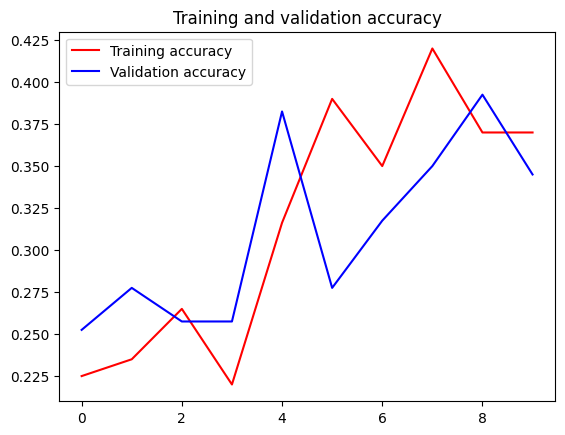

In [76]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
epochs = range(len(acc))
plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.show()

It's having trouble fitting this small dataset with so little training. We'll come back to this in Week 4! Also remember this is a 4-class problem, so random accuracy is only 25%.

# Part 2: Segmentation with U-Net

Load and resize images (this will take a few mintues)

In [77]:
# Set some parameters
IMG_WIDTH = 128
IMG_HEIGHT = 128
IMG_CHANNELS = 3
TRAIN_PATH = './data/segmentation/train/'
TEST_PATH = './data/segmentation/test/'

warnings.filterwarnings('ignore', category=UserWarning, module='skimage')
seed = 0
random.seed = seed
np.random.seed = seed

# Get train and test IDs
train_ids = next(os.walk(TRAIN_PATH))[1]
test_ids = next(os.walk(TEST_PATH))[1]

def data_generator(train_ids,test_ids):
    # Get and resize train images and masks
    X_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
    Y_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, 1), dtype=bool)
    print('Getting and resizing train images and masks ... ')
    sys.stdout.flush()
    for n, id_ in tqdm(enumerate(train_ids), total=len(train_ids)):
        path = TRAIN_PATH + id_
        img = imread(path + '/images/' + id_ + '.png')[:,:,:IMG_CHANNELS]
        img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True) # resize成128*128
        X_train[n] = img
        mask = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1), dtype=bool)
        for mask_file in next(os.walk(path + '/masks/'))[2]:
            mask_ = imread(path + '/masks/' + mask_file)
            mask_ = np.expand_dims(resize(mask_, (IMG_HEIGHT, IMG_WIDTH), mode='constant',
                                          preserve_range=True), axis=-1)
            mask = np.maximum(mask, mask_)
        Y_train[n] = mask

    # Get and resize test images
    X_test = np.zeros((len(test_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
    sizes_test = []
    print('Getting and resizing test images ... ')
    sys.stdout.flush()
    for n, id_ in tqdm(enumerate(test_ids), total=len(test_ids)):
        path = TEST_PATH + id_
        img = imread(path + '/images/' + id_ + '.png')[:,:,:IMG_CHANNELS]
        sizes_test.append([img.shape[0], img.shape[1]])
        img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
        X_test[n] = img

    print('Data Generate Done!')
    return X_train,Y_train,X_test,sizes_test

X_train,Y_train,X_test,sizes_test = data_generator(train_ids,test_ids)

Getting and resizing train images and masks ... 


100%|██████████| 300/300 [02:06<00:00,  2.38it/s]

Getting and resizing test images ... 



100%|██████████| 65/65 [00:02<00:00, 31.68it/s]

Data Generate Done!


Have a look at a training image and its target mask:

<ipython-input-78-f6b79fca59a6>:2: FutureWarning: `imshow` is deprecated since version 0.25 and will be removed in version 0.27. Please use `matplotlib`, `napari`, etc. to visualize images.
  imshow(X_train[ix])


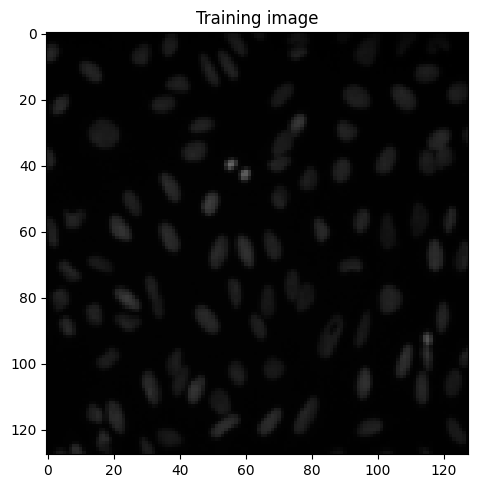

<ipython-input-78-f6b79fca59a6>:5: FutureWarning: `imshow` is deprecated since version 0.25 and will be removed in version 0.27. Please use `matplotlib`, `napari`, etc. to visualize images.
  imshow(np.squeeze(Y_train[ix]))


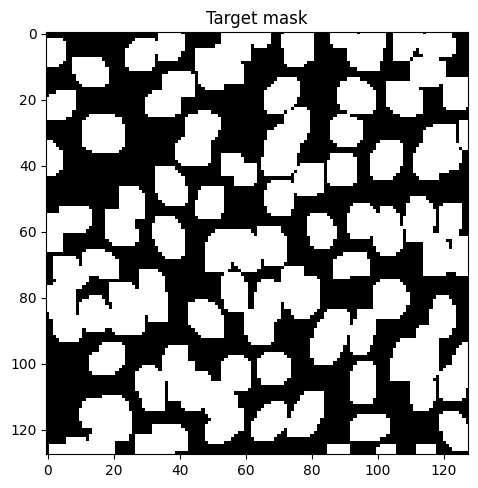

In [78]:
ix = random.randint(0, len(train_ids))
imshow(X_train[ix])
plt.title("Training image")
plt.show()
imshow(np.squeeze(Y_train[ix]))
plt.title("Target mask")
plt.show()

A U-Net encodes features with convolutional layers on the left side of the "U," then upsamples the features and concatenates them outputs from the left side to create "residual" connections:
![unet architecture](https://drive.google.com/uc?export=view&id=1G5zzpp_bWxmmT-OMxm6HVSxdFNyKFKIu)

Ours will follow the pattern above, but will be smaller. The first part of the 'U' will be similar to our image classification network. The main difference is we will need to store the layers in variables instead of using a sequential model, so we can use them for residual connections later. These variables are fed into further layers to build the network.

In [79]:
inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
s = tf.keras.layers.Rescaling(1./255) (inputs)

c1 = Conv2D(8, 3, activation='relu', padding='same') (s)
c1 = Conv2D(8, 3, activation='relu', padding='same') (c1)
p1 = MaxPooling2D(2) (c1)

c2 = Conv2D(16, 3, activation='relu', padding='same') (p1)
c2 = Conv2D(16, 3, activation='relu', padding='same') (c2)
p2 = MaxPooling2D(2) (c2)

c3 = Conv2D(32, 3, activation='relu', padding='same') (p2)
c3 = Conv2D(32, 3, activation='relu', padding='same') (c3)
p3 = MaxPooling2D(2) (c3)

c4 = Conv2D(64, 3, activation='relu', padding='same') (p3)
c4 = Conv2D(64, 3, activation='relu', padding='same') (c4)

**7. Upsample the output of the last Conv2D by 2x using [Conv2DTranspose](https://keras.io/api/layers/convolution_layers/convolution2d_transpose/) with 32 2x2 filters, 'relu' activation, and 'same' padding. Create a 'residual' connection by [concatenating](https://keras.io/api/layers/merging_layers/concatenate/) the upsampled layer to the appropriate layer from above. Feed the concatenation into 2 subsequent Conv2D layers, each with 32 3x3 filters, 'relu' activation, and 'same' padding.**
- Hint: Residual connections are the gray horizontal lines in the diagram above
- Hint: You may name the variables anything, as long as you feed the correct variable into the following layer.

In [80]:
# YOUR CODE HERE
c5 = Conv2DTranspose(32, (2,2), (2,2), activation='relu', padding='same') (c4)
r1 = concatenate([c3, c5])
c6 = Conv2D(32, (3,3), activation='relu', padding='same') (r1)
c7 = Conv2D(32, (3,3), activation='relu', padding='same') (c6)

**8. Repeat step 7, but with 16 filters in the Conv2D and Conv2DTranspose layers.**

In [81]:
# YOUR CODE HERE
c7 = Conv2DTranspose(16, (2,2), (2,2), activation='relu', padding='same') (c3)
r2 = concatenate([c2, c7])
c8 = Conv2D(16, (3,3), activation='relu', padding='same') (r2)
c9 = Conv2D(16, (3,3), activation='relu', padding='same') (c8)

**9. Repeat step 7 again, but with 8 filters in the Conv2D and Conv2DTranspose layers.**

In [82]:
# YOUR CODE HERE
c9 = Conv2DTranspose(8, (2,2), (2,2), activation='relu', padding='same') (c8)
r3 = concatenate([c1, c9])
c10 = Conv2D(8, (3,3), activation='relu', padding='same') (r3)
c11 = Conv2D(8, (3,3), activation='relu', padding='same') (c10)

**10. Since this is essentially a classification problem for every pixel, for the output layer, feed the latest Conv2D layer into a final Conv2D layer with a single 1x1 filter and 'sigmoid' activation. Store the output layer in a variable named `outputs`.**

In [83]:
# YOUR CODE HERE
outputs = Conv2D(1, (1,1), activation='sigmoid') (c11)

Compile and summarize the model:

In [84]:
model = Model(inputs=[inputs], outputs=[outputs])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_7             │ (None, 128, 128, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling_5 (Rescaling)   │ (None, 128, 128, 3)    │              0 │ input_layer_7[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_97 (Conv2D)        │ (None, 128, 128, 8)    │            224 │ rescaling_5[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_98 (Conv2D)        │ (None, 128, 128, 8)    │            584 │ conv2d_97[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_21          │ (None, 64, 64, 8)      │              0 │ conv2d_98[0][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_99 (Conv2D)        │ (None, 64, 64, 16)     │          1,168 │ max_pooling2d_21[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_100 (Conv2D)       │ (None, 64, 64, 16)     │          2,320 │ conv2d_99[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_22          │ (None, 32, 32, 16)     │              0 │ conv2d_100[0][0]       │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_101 (Conv2D)       │ (None, 32, 32, 32)     │          4,640 │ max_pooling2d_22[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_102 (Conv2D)       │ (None, 32, 32, 32)     │          9,248 │ conv2d_101[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_transpose_31       │ (None, 64, 64, 16)     │          2,064 │ conv2d_102[0][0]       │
│ (Conv2DTranspose)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_25            │ (None, 64, 64, 32)     │              0 │ conv2d_100[0][0],      │
│ (Concatenate)             │                        │                │ conv2d_transpose_31[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_107 (Conv2D)       │ (None, 64, 64, 16)     │          4,624 │ concatenate_25[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_transpose_32       │ (None, 128, 128, 8)    │            520 │ conv2d_107[0][0]       │
│ (Conv2DTranspose)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_26            │ (None, 128, 128, 16)   │              0 │ conv2d_98[0][0],       │
│ (Concatenate)             │                        │                │ conv2d_transpose_32[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_109 (Conv2D)       │ (None, 128, 128, 8)    │          1,160 │ concatenate_26[0][0]   │
├──────────────────────

 Total params: 27,145 (106.04 KB)

 Trainable params: 27,145 (106.04 KB)

 Non-trainable params: 0 (0.00 B)

Train the model for 5 epochs:

In [85]:
epochs = 10
batch_size = 8
validation_split = 0.1
model.fit(X_train, Y_train, validation_split=validation_split,
                        batch_size=batch_size, epochs=epochs)

Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_185']
Received: inputs=Tensor(shape=(None, 128, 128, 3))
  warnings.warn(msg)


34/34 ━━━━━━━━━━━━━━━━━━━━ 10s 138ms/step - accuracy: 0.7584 - loss: 0.6610 - val_accuracy: 0.7055 - val_loss: 0.6124
Epoch 2/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.7404 - loss: 0.5593 - val_accuracy: 0.7274 - val_loss: 0.5365
Epoch 3/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.7773 - loss: 0.4655 - val_accuracy: 0.7313 - val_loss: 0.4428
Epoch 4/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.8005 - loss: 0.3891 - val_accuracy: 0.8629 - val_loss: 0.3172
Epoch 5/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.8826 - loss: 0.2813 - val_accuracy: 0.8717 - val_loss: 0.3266
Epoch 6/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9073 - loss: 0.2301 - val_accuracy: 0.9132 - val_loss: 0.2155
Epoch 7/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9255 - loss: 0.1891 - val_accuracy: 0.9168 - val_loss: 0.2000
Epoch 8/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9345 - loss: 0.1720 - val_accuracy: 0.9227 - val_loss: 

Make predictions:

In [86]:
preds_train = model.predict(X_train[:int(X_train.shape[0]*0.9)], verbose=1) # (603, 128, 128, 1)
preds_val = model.predict(X_train[int(X_train.shape[0]*0.9):], verbose=1)   # (67, 128, 128, 1)
preds_test = model.predict(X_test, verbose=1)  # (65, 128, 128, 1)

# Threshold predictions
preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_val_t = (preds_val > 0.5).astype(np.uint8)
preds_test_t = (preds_test > 0.5).astype(np.uint8)

# Create list of upsampled test masks
preds_test_upsampled = []  # (65,)
for i in range(len(preds_test)):
    preds_test_upsampled.append(resize(np.squeeze(preds_test[i]),
                                       (sizes_test[i][0], sizes_test[i][1]), # 回到原来的尺寸
                                       mode='constant', preserve_range=True))

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_185']
Received: inputs=Tensor(shape=(32, 128, 128, 3))
  warnings.warn(msg)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 246ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step


Choose a random training image and visualize our model's predicted segmentation (rerun for a new image):

<ipython-input-87-bb0b919f6545>:2: FutureWarning: `imshow` is deprecated since version 0.25 and will be removed in version 0.27. Please use `matplotlib`, `napari`, etc. to visualize images.
  imshow(X_train[ix])


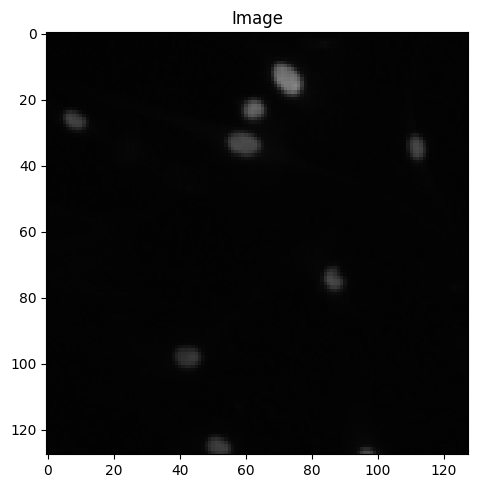

<ipython-input-87-bb0b919f6545>:5: FutureWarning: `imshow` is deprecated since version 0.25 and will be removed in version 0.27. Please use `matplotlib`, `napari`, etc. to visualize images.
  imshow(np.squeeze(Y_train[ix]))# 128*128*1


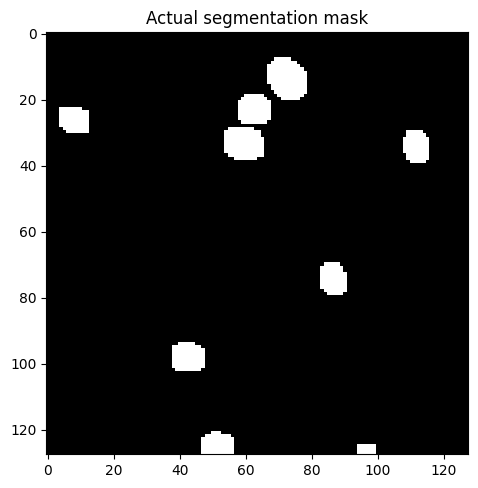

<ipython-input-87-bb0b919f6545>:8: FutureWarning: `imshow` is deprecated since version 0.25 and will be removed in version 0.27. Please use `matplotlib`, `napari`, etc. to visualize images.
  imshow(np.squeeze(preds_train_t[ix])) # 128*128*1


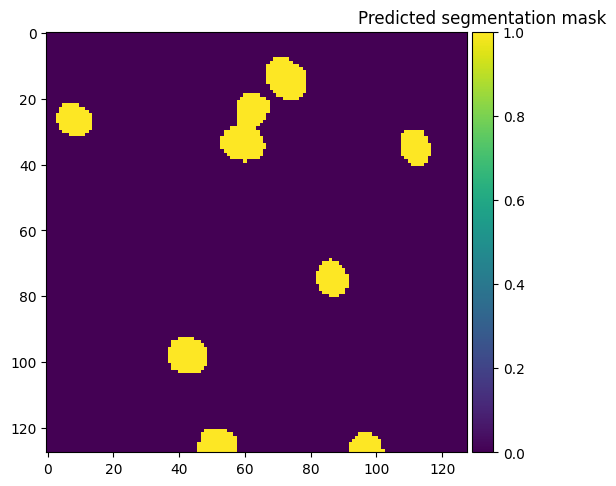

In [87]:
ix = random.randint(0, len(preds_train_t))
imshow(X_train[ix])
plt.title('Image')
plt.show()
imshow(np.squeeze(Y_train[ix]))# 128*128*1
plt.title('Actual segmentation mask')
plt.show()
imshow(np.squeeze(preds_train_t[ix])) # 128*128*1
plt.title('Predicted segmentation mask')
plt.show()

Try experimenting with different numbers of layers and filters!